In [67]:
import os
os.chdir('/home/jknize/main/repo/CSC578/detectron2')

Simple ResNet object detection evaluation using pre-trained backbone

In [ ]:
# from detectron2.structures import BoxMode

# # DatasetCatalog.remove("sub_trn")
# # MetadataCatalog.remove("sub_trn")
# def get_sub_dicts(img_dir):
#     json_file =  "../datasets/coco/annotations/filtered_instances_train2017.json"
#     with open(json_file) as f:
#         imgs_anns = json.load(f)

#     dataset_dicts = []
#     for idx, v in enumerate(imgs_anns.values()):
#         record = {}
        
#         filename = os.path.join(img_dir, v["filename"])
#         height, width = cv2.imread(filename).shape[:2]
        
#         record["file_name"] = filename
#         record["image_id"] = idx
#         record["height"] = height
#         record["width"] = width
      
#         annos = v["regions"]
#         objs = []
#         for _, anno in annos.items():
#             assert not anno["region_attributes"]
#             anno = anno["shape_attributes"]
#             px = anno["all_points_x"]
#             py = anno["all_points_y"]
#             poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
#             poly = [p for x in poly for p in x]

#             obj = {
#                 "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
#                 "bbox_mode": BoxMode.XYXY_ABS,
#                 "segmentation": [poly],
#                 "category_id": 0,
#             }
#             objs.append(obj)
#         record["annotations"] = objs
#         dataset_dicts.append(record)
#     return dataset_dicts

# DatasetCatalog.register("sub_trn", lambda d=d: get_sub_dicts("../datasets/coco_cls"))
# MetadataCatalog.get("sub_trn").set(thing_classes=["person", "dog", "bottle", "chair", "book"])
# sub_metadata = MetadataCatalog.get("sub_trn")

Create dataset

In [81]:
from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_val_dataset", {}, "../datasets/coco/annotations/filtered_instances_val2017.json", "../datasets/coco/val2017")
register_coco_instances("full_train_dataset2", {}, "../datasets/coco/annotations/instances_train2017.json", "../datasets/coco/train2017")
register_coco_instances("full_val_dataset", {}, "../datasets/coco/annotations/instances_val2017.json", "../datasets/coco/val2017")

Check that dataset loaded correctly by sampling 3 random images

WARNING [11/09 20:14:58 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/09 20:14:58 d2.data.datasets.coco]: Loaded 5000 images in COCO format from ../datasets/coco/annotations/instances_val2017.json


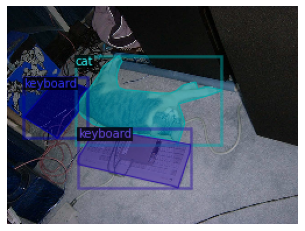

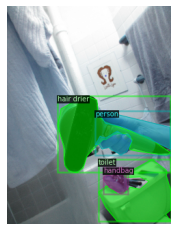

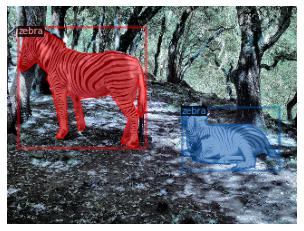

In [82]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
import random
import cv2
import matplotlib.pyplot as plt

my_dataset_metadata = MetadataCatalog.get("full_val_dataset")# .set(thing_classes=["person", "dog", "bottle", "chair", "book"])
dataset_dicts = DatasetCatalog.get("full_val_dataset")

# Visualize 3 random images
for d in random.sample(dataset_dicts, 3):
    file_name = d['file_name']
    img = cv2.imread(d["file_name"]) 
    if img is None:
        print(f"Failed to load image: {d['file_name']}")
        continue 
     
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)  # Draw annotations on the image
    output_image = out.get_image()[:, :, ::-1]  # Convert back from BGR to RGB for matplotlib
    plt.imshow(output_image)
    plt.axis("off")  # Turn off axis
    plt.show()

In [85]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# load simple ResNet-50 model without FPN
cfg = get_cfg()
cfg.merge_from_file("configs/COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")
# use COCO-pretrained detection weights for quick evaluation
cfg.MODEL.WEIGHTS = "../../../model_final_721ade.pkl" # downloaded from detectron2 MODEL_ZOO.md
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 

cfg.DATASETS.TRAIN = ("full_train_dataset2",)
cfg.DATASETS.TEST = ("full_val_dataset",)
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5

predictor = DefaultPredictor(cfg)
# val_loader = build_detection_test_loader(cfg, "full_val_dataset")

# metrics = inference_on_dataset(DefaultTrainer.build_model(cfg), val_loader, evaluator)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
evaluator = COCOEvaluator("full_val_dataset", cfg, False, output_dir="./knize/output")
results = trainer.test(cfg, model=trainer.model, evaluators=[evaluator])
print("Evaluation Results:")
for key, value in results.items():
    print(f"{key}: {value}")
# print("Evaluation Results:", metrics)

# print(inference_on_dataset(predictor.model, val_loader, evaluator)) # from other tutorial
# got nan from adding .set to dataset
# got low scores from adding cfg.DATASETS.TEST
# 40,000 validation images... possible reason for low scores

[11/09 20:22:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ../../../model_final_721ade.pkl ...
[11/09 20:22:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
     